In [74]:
from a2c.model import Model
from a2c.runner import Runner
import tensorflow as tf
from bandits import *
import numpy as np
from collections import defaultdict
import scipy.signal
from scipy.stats import spearmanr

In [164]:
nunits = 48

model_config = {'scope' : 'agent_test', 'lstm_units' : nunits, 
                'gamma' : 0.5, 'ent_coef' : 0.05, 'vf_coef' : 0.5,
                'max_grad_norm' : 50,  
                'lr' : 5e-4, 'lr_half_period' : 1500000, 'anneal_lr' : False, 
                'path': './experiments/fullmodel/'}

nactions = 2
nobs = 4

tf.reset_default_graph()
sess = tf.Session()

model = Model(nactions, nobs, sess = sess, **model_config)
model.load_model()

nunits = model_config['lstm_units']

runner = Runner(model)

Successfully loaded model "agent_test":
  "agent_test" was trained for 301500 epochs, using 24120000 timesteps
  "agent_test" has following parameters: lr = 0.000500


In [155]:
tasks = []
t_names = ['0_stay', '0_switch', '1_stay', '1_switch', '2_stay', '2_switch']

for b_func in [zero_order_bandit, first_order_bandit, second_order_bandit]:
    for P_int in [(0.05, 0.35), (0.65, 0.95)]:
        bandit = b_func(P_intervals = [P_int])
        bandit.name = bandit.name + str(P_int)
        tasks.append(bandit)

In [156]:
rewards, stats = runner.run_evaluation(15, tasks)

In [165]:
units_vars = []
units_vars_states = []

for t in tasks:
    name = t.name
    print('\nTask %s:' % name)
    print('Mean reward:', np.mean(rewards[name]))
    
    lstm_o = np.reshape(stats[name]['lstm_outputs'], (-1, nunits))
    lstm_s = np.array(stats[name]['lstm_states'],)[:, :, 0, 0].reshape((-1, nunits))
    
    lstm_o = (lstm_o - np.min(lstm_o)) / (np.max(lstm_o) - np.min(lstm_o))
    lstm_s = (lstm_s - np.min(lstm_s)) / (np.max(lstm_s) - np.min(lstm_s))
    
    units_vars.append(np.var(lstm_o, 0))
    units_vars_states.append(np.var(lstm_s, 0))
    
units_vars = np.array(units_vars)
units_vars_states = np.array(units_vars_states)


Task 0th_order(0.05, 0.35):
Mean reward: 62.4

Task 0th_order(0.65, 0.95):
Mean reward: 58.4

Task 1st_order(0.05, 0.35):
Mean reward: 59.86666666666667

Task 1st_order(0.65, 0.95):
Mean reward: 59.266666666666666

Task 2nd_order(0.05, 0.35):
Mean reward: 63.13333333333333

Task 2nd_order(0.65, 0.95):
Mean reward: 59.13333333333333


### Units variance

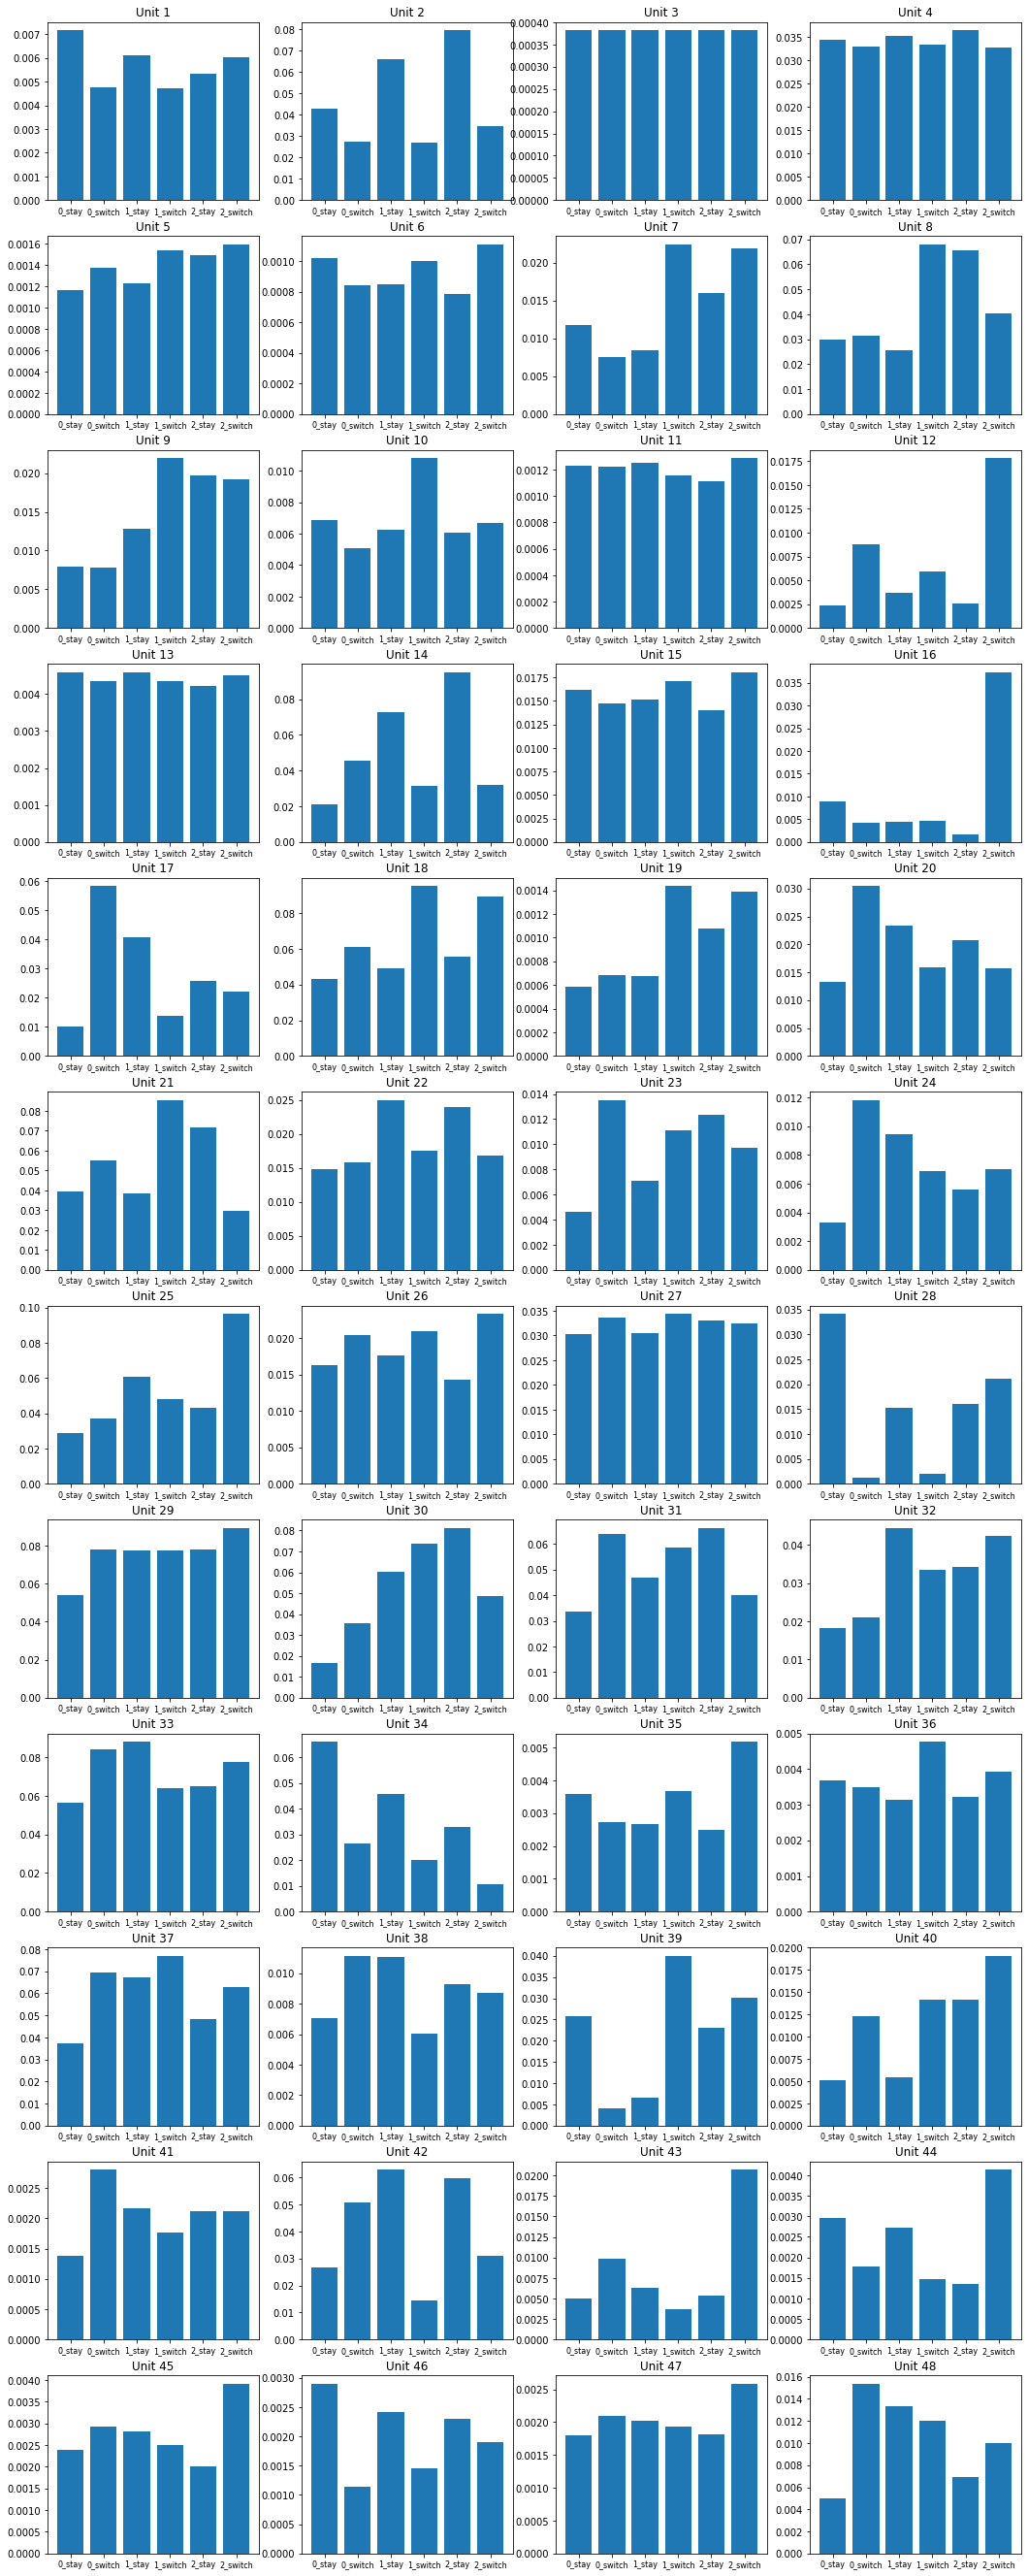

In [171]:
# Variance of units' outputs

plt.figure(figsize = (18, nunits))
for i in range(0, nunits // 4):
   
    for j in range(0, 4):
        plt.subplot(nunits // 4, 4, i * 4 + j + 1)
        plt.bar(np.arange(0, len(tasks)), units_vars[:, i * 4 + j])
        
        plt.xticks(np.arange(6), t_names, fontsize = 8)
        #plt.xlabel('Task')
        #plt.ylabel('Variance')
        plt.title('Unit %d' % (i * 4 + j + 1))
    

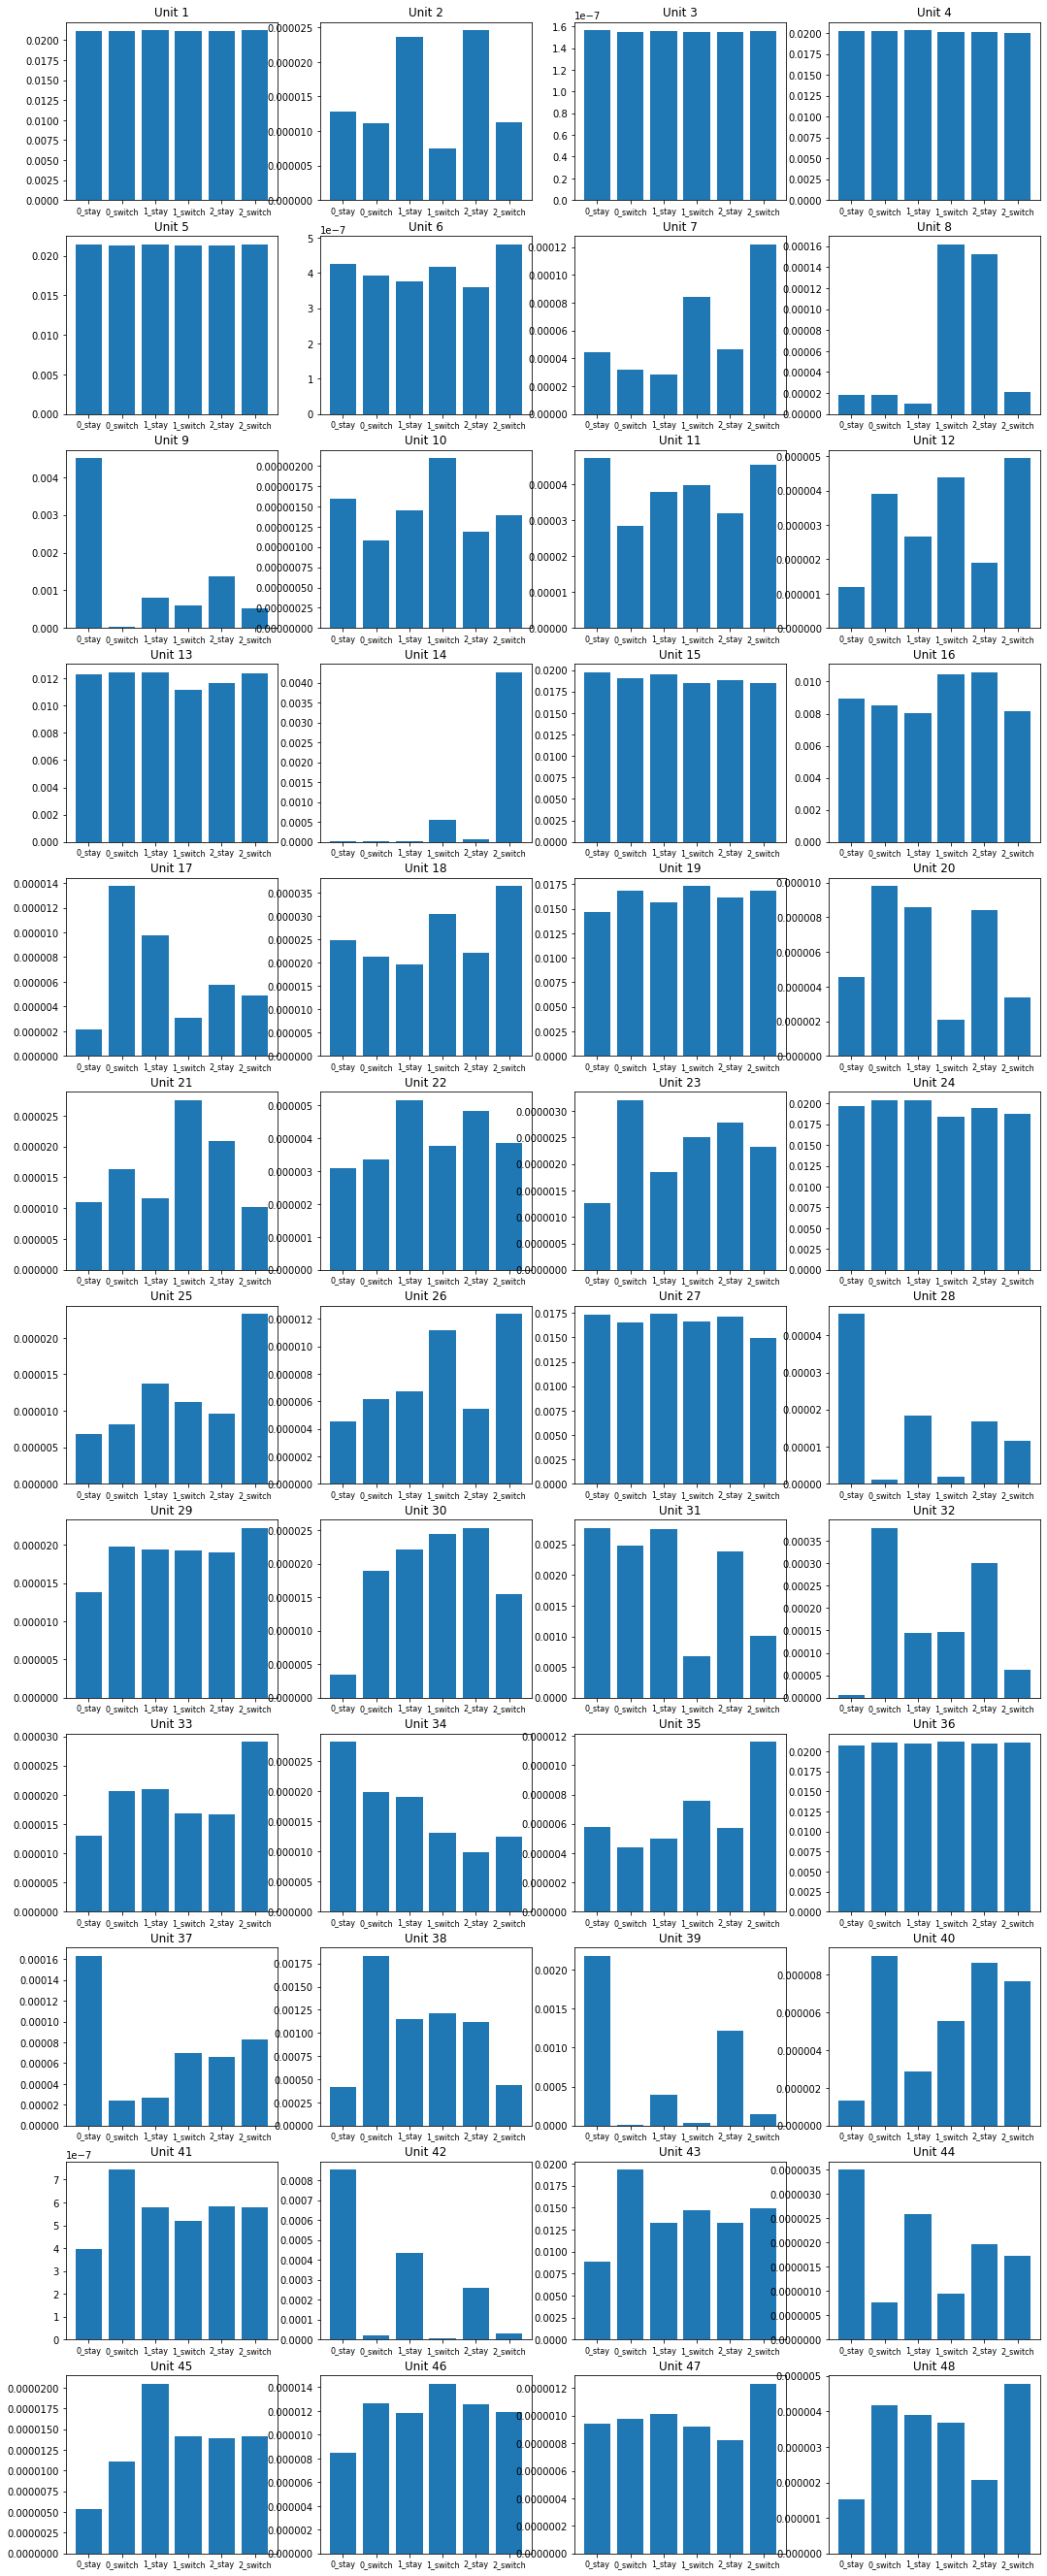

In [172]:
# Variance of units' states

plt.figure(figsize = (18, nunits))
for i in range(0, nunits // 4):
   
    for j in range(0, 4):
        plt.subplot(nunits // 4, 4, i * 4 + j + 1)
        plt.bar(np.arange(0, len(tasks)), units_vars_states[:, i * 4 + j])
        
        plt.xticks(np.arange(6), t_names, fontsize = 8)
        #plt.xlabel('Task')
        #plt.ylabel('Variance')
        plt.title('Unit %d' % (i * 4 + j + 1))
    

### FTV score

In [ ]:
plt.figure(figsize = (18, nunits))
for i in range(0, nunits // 4):
   
    for j in range(0, 4):
        plt.subplot(nunits // 4, 4, i * 4 + j + 1)

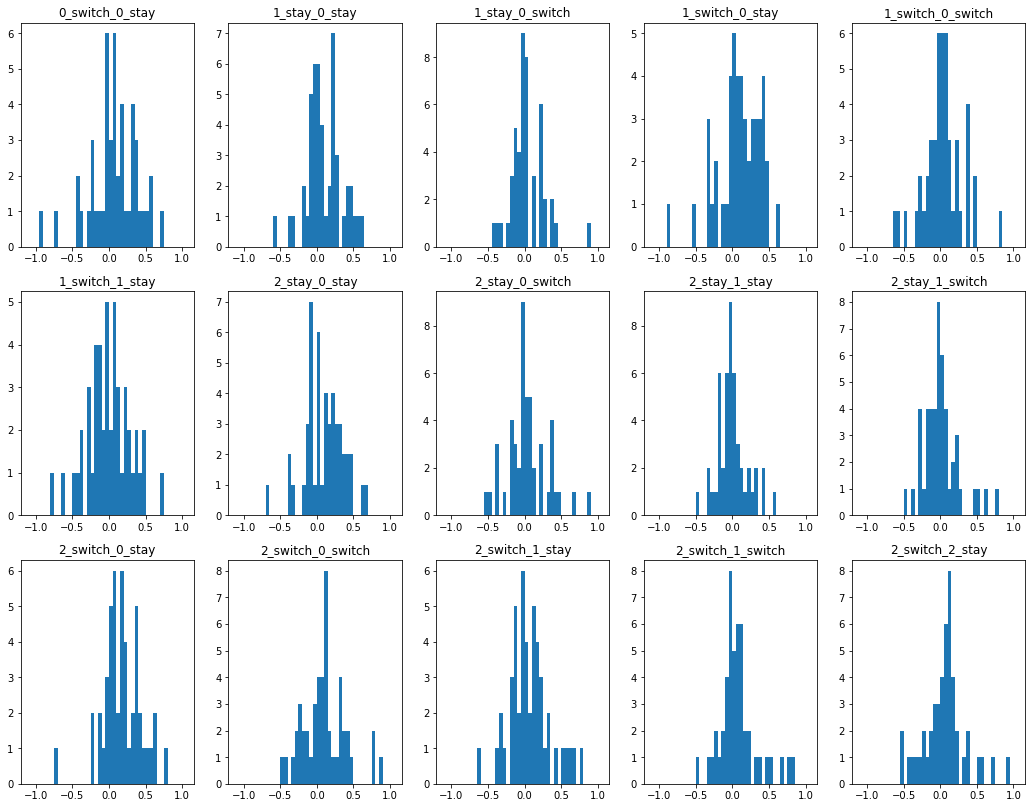

In [174]:
plt.figure(figsize = (18, 14))
n = 0 
bins = np.arange(-1.1, 1.1, 0.05)


for i in range(len(tasks)):
    for j in range(i):
        n += 1
        plt.subplot(3, 5, n)
    
        t1 = tasks[i]
        t2 = tasks[j]
    
        tv1, tv2 = units_vars[i], units_vars[j]
        plt.title(t_names[i] + '_' + t_names[j])
        _ = plt.hist((tv1 - tv2) / (tv2 + tv1), bins = bins)
        _ = plt.xticks(np.arange(-1, 1.01, 0.5, ))